# Toy problem

/home/user/miniconda/envs/cil/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


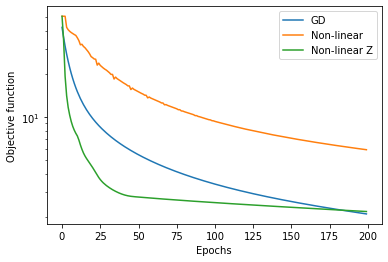

In [1]:
import numpy as np
import matplotlib.pyplot as plt
n = 100
np.random.seed(0)
x_true = np.random.rand(n)
A = np.random.randn(n,n)

y = A @ x_true + np.random.rand(n)*0.1
max_iter = 200
step_size = 0.001
func_x = lambda x: (x - step_size * (A.T @ (A@x - y )))


norm = []
accel = []

x = np.zeros_like(x_true)
Y = np.zeros_like(x)[None].T
k = 10
lam = 0.001
for i in range(max_iter):
    if i < 3:
        Y = np.append(Y, x[None].T, axis=1)
    elif i < k - 1:
        Y = np.append(Y, x[None].T, axis=1)
        R = Y[:,1:] - Y[:,:-1]
        c_lambda = np.linalg.lstsq(R.T@R+lam*np.eye(R.shape[1]), np.ones(R.shape[1]),rcond=None)[0]
        c_lambda /= np.sum(c_lambda) # effectively a normalisation step
        x = Y[:,1:]@c_lambda
        
        x = func_x(x)
        Y[:,-1] = x
    else:
        Y = np.append(Y.copy(), x[None].T.copy(), axis=1)
        X = Y[:,1:].copy()
        Y = Y[:,:-1].copy()
        R = X - Y
        c_lambda = np.linalg.lstsq(R.copy().T@R.copy()+lam*np.eye(R.copy().shape[1]), np.ones(R.copy().shape[1]),rcond=None)[0]
        c_lambda /= np.sum(c_lambda) # effectively a normalisation step
        x = X@c_lambda
        Y = X
        
        x = func_x(x)
        Y[:,-1] = x
    
    accel.append(np.linalg.norm(y-A@x))

x = np.zeros_like(x_true)

for i in range(max_iter):
    x = func_x(x)
    norm.append(np.linalg.norm(y-A@x))

x = np.zeros_like(x_true)

beta = -1

func_x = lambda x: (x - step_size * (A.T @ (A@x - y )))
def func_xyz(x):
    return func_x(x[:,0])[None].T

xstand = np.zeros_like(x_true)[None].T
x0 = np.zeros_like(x_true)[None].T
mem = np.zeros_like(x_true)[None].T
Fmem = np.zeros_like(x_true)[None].T
mem = np.hstack((mem, x0))
Fmem = np.hstack((Fmem, func_xyz(x0)))


accel_z = []
for i in range(max_iter):
    xstand = func_xyz(xstand)
    Res = Fmem-mem
    e = np.ones((Res.shape[1], 1))
    Res_norm = np.linalg.norm(Res,2)
    c_la = np.linalg.lstsq(Res.T@Res + lam * Res_norm * np.eye(Res.shape[1]), e)[0]
    c_la /= np.sum(c_la)
    x0 = beta * mem @ c_la + (1-beta) * Fmem @ c_la
    if i == 0:
        mem = x0
        Fmem = func_xyz(x0)
    elif i <= (k-1):
        mem = np.hstack((mem, x0))
        Fmem = np.hstack((Fmem, func_xyz(x0)))
    else:
        mem = np.hstack((mem[:, 1:], x0))
        Fmem = np.hstack((Fmem[:, 1:], func_xyz(x0)))

    accel_z.append(np.linalg.norm(A@x0[:,0]-y))


plt.figure()
plt.semilogy(norm, label="GD")
plt.semilogy(accel, label="Non-linear")
plt.semilogy(accel_z, label="Non-linear Z")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.show()

In [2]:
from cil.framework import  AcquisitionGeometry
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import IndicatorBox, LeastSquares
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D

import matplotlib.pyplot as plt

import numpy as np

In [3]:
# Define SAGAGradientFunction
import sys
cil_path = '/home/user/CILworkspace/CIL/'
fun_path = 'Wrappers/Python/cil/optimisation/functions'
sys.path.append(cil_path + fun_path)
from SubsetSumFunction import SumFunction

/home/user/miniconda/envs/cil/lib/python3.7/site-packages/cil/utilities/display.py:309: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


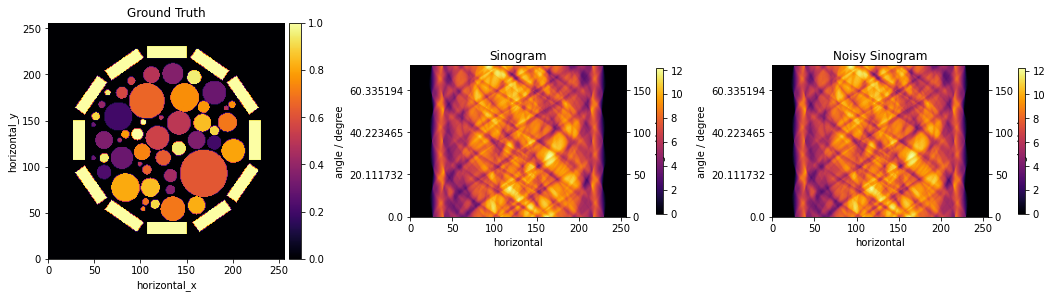

In [4]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device='gpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
noise_scale = 0.05

gaussian_var = 0.5 * noise_scale
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size=ag.shape)

noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array < 0] = 0

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title=['Ground Truth', 'Sinogram', 'Noisy Sinogram'], num_cols=3, cmap='inferno')

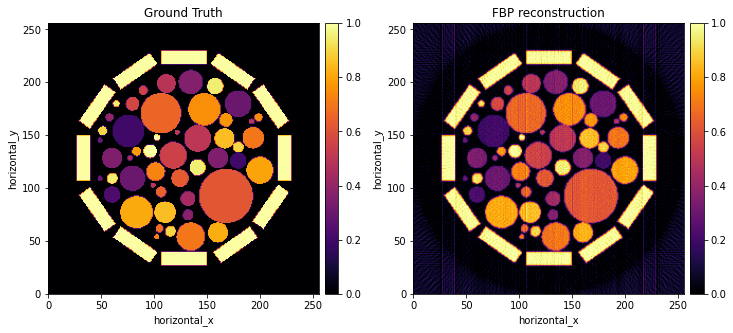

In [5]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig, ag,  device = 'gpu')(noisy_sino)

# Show reconstructions
show2D([phantom, fbp_recon],
       title = ['Ground Truth','FBP reconstruction'],
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

In [6]:
class GradientDescent(Algorithm):
    """
        Gradient Descent w/o Armijo rule
        Convergence guarantee: step-size < 2/L where L is the lipschitz constant
        of the gradient of the objective function
    """

    def __init__(self, initial=None, objective_function=None, step_size=1, **kwargs):
        super(GradientDescent, self).__init__(**kwargs)

        set_up(initial=initial, objective_function=objective_function, step_size=step_size)

    def set_up(self, initial, objective_function, step_size):
        x = initial.copy()
        objective_function = objective_function
        x_update = initial.copy()
        self.step_size = step_size
        self.update_objective()
        self.update_step_size = False
        self.configured = True

    def update(self):
        '''Single iteration'''

        self.x_update = self.objective_function.gradient(self.x)

        self.x_update *= -self.step_size
        self.x += self.x_update

    def update_objective(self):
        self.loss.append(self.objective_function(self.x))

In [ ]:

class ISTA(Algorithm):
    """
        Iterative Shrinkage-Thresholding Algorithm
        Goal: minimize f + g with f smooth, g simple

        Convergence guarantee:
        - f,g convex
        - step-size < 1/L where the gradient of f is L-Lipschitz

        See Section 3 of Beck, Amir, and Marc Teboulle,
        "A fast iterative shrinkage-thresholding algorithm for linear inverse problems."
        SIAM journal on imaging sciences 2.1 (2009)
    """

    def __init__(self, initial=None, f=None, g=None, step_size=1, n_subsets=1, **kwargs):
        super(ISTA, self).__init__(**kwargs)

        self.set_up(initial=initial, f=f, g=g, step_size=step_size, n_subsets=n_subsets)

    def set_up(self, initial, f, g, step_size, n_subsets):
        self.f = f
        self.g = g
        self.x = initial.copy()
        self.objective_function = SumFunction(f, g)
        self.x_update = initial.copy()
        self.step_size = step_size
        self.update_objective()
        self.update_step_size = False
        self.configured = True
        self.n_subsets = n_subsets

    def update(self):
        '''Single iteration'''

        self.x_update = self.f.gradient(self.x)
        self.x_update *= -self.step_size
        self.x += self.x_update
        self.x = self.g.proximal(self.x, self.step_size/self.n_subsets)

    def update_objective(self):
        self.loss.append(self.objective_function(self.x))

# ISTA
num_epochs = 100
f_gd = LeastSquares(A, noisy_sino)
initial = ig.allocate(0)
step_size = 1 / f_gd.L
g_fun = IndicatorBox(lower=0)
ista = ISTA(initial=initial, f=f_gd, g=g_fun,
                     step_size=step_size, update_objective_interval=1,
                     max_iteration=1000)
ista.run(num_epochs, verbose=0)

show2D([ista.solution],
       title=["ISTA"],
       origin="upper",
       fix_range=(0,1), num_cols=2,
       cmap='inferno')

plt.figure()
plt.semilogy(ista.objective, label="ISTA")

plt.legend()
plt.ylabel('Epochs')
plt.xlabel('Objective function')
plt.show()

In [7]:
class Non_linear_acceleration(Algorithm):
    """
    """

    def  __init__(self, algo=None, non_linear_regularisation_parameter=None, k=None, beta=None, **kwargs):

        super(Non_linear_acceleration, self).__init__(**kwargs)

        self.set_up(algo=algo, non_linear_regularisation_parameter=non_linear_regularisation_parameter, k=k, beta=beta)


    def set_up(self, algo, non_linear_regularisation_parameter, k, beta):
        self.algo = algo
        self.non_linear_regularisation_parameter = non_linear_regularisation_parameter
        self.k = k
        self.beta = beta
        self.configured = True
        # Create Residual of zeros
        self.len_x_vec = self.algo.x.shape[0]*self.algo.x.shape[1]
        self.x = self.algo.x.copy()
        self.update_step_size = False
        self.mem = np.zeros((self.len_x_vec,1))
        self.Fmem =  np.zeros((self.len_x_vec,1))

    def update(self):
        self.algo.update()

        x = self.algo.x.copy()
        Res = self.Fmem.copy()-self.mem.copy()
        e = np.ones((Res.shape[1], 1))
        Res_norm = 1#np.linalg.norm(Res,2)
        c_la = np.linalg.lstsq(Res.T@Res + lam * Res_norm * np.eye(Res.shape[1]), e)[0]
        c_la /= np.sum(c_la)
        x_extra = beta * self.mem @ c_la + (1-beta) * self.Fmem @ c_la
        
        self.algo.x.fill(np.reshape(x_extra,self.algo.x.shape))

        self.x = self.algo.x.copy()
        if self.algo.g.lower is not None and self.algo.g.upper is not None:
            self.x = self.algo.g.proximal(self.x,1)

        self.algo.update()

        if self.iteration == 0:
            self.mem = x_extra.copy()
            self.Fmem = self.algo.x.copy().array.ravel()[None].T
        elif self.iteration <= (self.k-1):
            self.mem = np.hstack((self.mem, x_extra))
            self.Fmem = np.hstack((self.Fmem, self.algo.x.copy().array.ravel()[None].T))
        else:
            self.mem = np.hstack((self.mem[:, 1:], x_extra))
            self.Fmem = np.hstack((self.Fmem[:, 1:], self.algo.x.copy().array.ravel()[None].T))
        self.algo.x.fill(x)
            
    def update_objective(self):
        self.loss.append(self.algo.objective_function(self.x))

ista2 = ISTA(initial=initial, f=f_gd, g=g_fun,
                     step_size=step_size, update_objective_interval=1,
                     max_iteration=1000)

check = Non_linear_acceleration(ista2, non_linear_regularisation_parameter = 1e-5, k = 5, beta = 10, max_iteration=1000)
check.run(100, verbose=0)

print()
show2D([check.solution],
       title=["Check"],
       origin="upper",
       fix_range=(0,1), num_cols=2,
       cmap='inferno')

plt.figure()
plt.semilogy(check.objective, label="Non-linear Acc")
plt.semilogy(ista.objective, label="ISTA")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.show()
print(check.objective)
print(ista.objective)

NameError: name 'ISTA' is not defined